## Creating Soundings DataFrame

In [318]:
import pandas as pd
import seaborn as sb
from func import cal_buoyancy, sounding_cal
import glob
import os
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import math
import pint
from pydoc import help
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from pyhdf.SD import *
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from numpy import load, asarray, save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [403]:
#read in warm season 11:30CDT files

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/sondewnpn"

# file name looks like: sgpsondewnpnC1.b1.20211023.214500.cdf

# all files in directory
files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".cdf")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    year_month = file_name.split('.')[2]
    if len(year_month) == 8:
        year = int(year_month[0:4])
        month = int(year_month[4:6])
        day = int(year_month[6:8])
        hours_mins_seconds = file_name.split('.')[3]
        hour = int(hours_mins_seconds[0:2])
        if 5 <= month <= 9 and hour == 17:
            filtered_files.append(file)

dfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    dfs.append(ds)

In [404]:
def time_adjustment(file):
    bt = file.variables["base_time"].data
    t = file.coords["time"].data[0]
    t_off = file.variables["time_offset"].data[0]
    
    bt = pd.Timestamp(bt)
    t_off = pd.Timestamp(t_off)
    
    yr = bt.year
    month = bt.month
    day = bt.day
    
    if bt.hour == 0 and bt.minute == 0 and bt.second == 0:
        hr = t_off.hour
        minute = t_off.minute
        second = t_off.second
    else:
        hr = bt.hour
        minute = bt.minute
        second = bt.second
    
    time_final = (yr, month, day, hr, minute, second)
    time_final = datetime.datetime(*time_final)
    return(time_final)

In [405]:
#clean relevant variables: pressure, dewpoint, height

df_fill_nans = []
# Iterate through the list of xarray datasets

for df in dfs:
    time = time_adjustment(df)

    #clean pressure
    pres = df.variables['pres'].data
    
    pres_lower_bound = 0
    pres_upper_bound = 1100

    mask = (pres < pres_lower_bound) | (pres > pres_upper_bound)

    pres_clean = np.where(mask, np.nan, pres)
    
    #clean altitude
    alt = df.variables['alt'].data
    
    alt_lower_bound = 313
    alt_upper_bound = 30000
    
    mask = (alt < alt_lower_bound) | (alt > alt_upper_bound)

    alt_clean = np.where(mask, np.nan, alt)
    
    #clean dewpoint
    dp = df.variables['dp'].data

    dp_lower_bound = -110
    dp_upper_bound = 50
    
    mask = (dp < dp_lower_bound) | (dp > dp_upper_bound)

    dp_clean = np.where(mask, np.nan, dp)
    
#   clean temperature
    tdry = df.variables['tdry'].data
    
    tdry_lower_bound = -200
    tdry_upper_bound = 200
    
    mask = (tdry < tdry_lower_bound) | (tdry > tdry_upper_bound)
    
    tdry_clean = np.where(mask, np.nan, tdry)
    
    cleaned_arrays=(time, pres_clean, alt_clean, dp_clean, tdry_clean)
    
    df_fill_nans.append(cleaned_arrays)
    
df_fill_nans = pd.DataFrame(df_fill_nans, columns=['time','pres','alt','dp','tdry'])
df_fill_nans = df_fill_nans.set_index('time')

#dropping duplicates along index
df_fill_nans = df_fill_nans[~df_fill_nans.index.duplicated(keep='first')]

In [427]:
df_fill_nans.shape

(2437, 4)

In [428]:
#warm season soundings final df 

print(df_fill_nans.shape)
def count_nans(arr):
    return np.isnan(arr).sum()

def count_non_nan(arr):
    return arr.shape[0]

def get_max_alt(arr):
    return arr.max()

# Apply the function to the specified column and create a mask for rows with <= 10 NaN values
max_nans = 0

mask = df_fill_nans['pres'].apply(count_nans) <= max_nans
df_fill_nans = df_fill_nans[mask]

mask = df_fill_nans['alt'].apply(count_nans) <= max_nans
df_fill_nans = df_fill_nans[mask]

mask = df_fill_nans['dp'].apply(count_nans) <= max_nans
df_fill_nans = df_fill_nans[mask]

mask = df_fill_nans['tdry'].apply(count_nans) <= max_nans
df_fill_nans = df_fill_nans[mask]

#adding condition that every file must have at least 1000 observations (using pressure as the proxy)
min_elems = 2500
mask = df_fill_nans['pres'].apply(count_non_nan) >= min_elems
df_fill_nans = df_fill_nans[mask]

#adding this in order to interpolate up to 12km, but remove this mask if trying to reproduce specific humidity up to 4km only
height_threshold = 20000
mask = df_fill_nans['alt'].apply(get_max_alt) >= height_threshold
soundings = df_fill_nans[mask]

print("final df: ",soundings.shape)

(2437, 4)
final df:  (2397, 4)


## Creating Soil Moisture Dataframe

In [408]:
#read in soil moisture files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1"

#files are .nc
#look like: sgpokmsoilX1.c1.20120901.000000.nc

files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".nc")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    if file_name.startswith("sgpokmsoilX1"):
        year_month = file_name.split('.')[2]
        if len(year_month) == 8:
            year = int(year_month[0:4])
            month = int(year_month[4:6])
            day = int(year_month[6:8])
            hours_mins_seconds = file_name.split('.')[3]
            hour = int(hours_mins_seconds[0:2])
            if 5 <= month <= 9 and 2020 > year > 2000:
                filtered_files.append(file)

soildfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    soildfs.append(ds)

In [409]:
#clean soil moisture data
def clean_fwi(df):
    
    min_fwi = 0

    max_fwi = 1

    fwi = df.variables['fractional_water_index'].data
          
    mask = ((fwi < min_fwi) | (fwi > max_fwi))

    fwi = np.where(mask, np.nan, fwi)
    return(fwi)

In [410]:
#final soil moisture df 

closest_station = (36.75442886352539, -97.2545166015625)

def find_ll_index(latarray,findlat):
    latindex = np.where(latarray == findlat)
    lat_pos = latindex[0][0]
    return lat_pos

fwi_tuples=[]
for df in soildfs:
    date = time_adjustment(df)
    latarray = df.variables['lat'].data
    lonarray = df.variables['lon'].data
    station = find_ll_index(latarray,closest_station[0])
    fwi = clean_fwi(df)
    
    #[0] means first observation of the day, [1] means 25cm depth
    fwi = fwi[0][1][station]
    fwi_tuple = (date,fwi)
    fwi_tuples.append(fwi_tuple)

fwidf = pd.DataFrame(fwi_tuples,columns=['date','fwi'])
fwidf = fwidf.dropna()
fwidf.shape

(2812, 2)

## Creating Precipitation DataFrame

In [414]:
#read in precipitation files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/abrfc_final"

#files either .cdf or .nc
#file name looks like: sgpabrfcprecipX1.c1.19971231.000000.custom.cdf
#file name looks like: sgpabrfcprecipX1.c1.20171231.000000.custom.nc

files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".cdf") or file.endswith(".nc")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    year_month = file_name.split('.')[2]
    if len(year_month) == 8:
        year = int(year_month[0:4])
        month = int(year_month[4:6])
        day = int(year_month[6:8])
        hours_mins_seconds = file_name.split('.')[3]
        hour = int(hours_mins_seconds[0:2])
        if 5 <= month <= 9 and year > 2000:
            filtered_files.append(file)

pdfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    pdfs.append(ds)

In [416]:
#clean precipitation -- creating a list of dfs in pdfs with valid precipitation arrays 
dfsc = []
for df in pdfs: 
    min_p = 0
    
    #equivalent to 250mm of rain per hour
    max_p = 25000

    precip = df.variables['precip'].data
          
    mask = ((precip < min_p) | (precip > max_p))

    precip_clean = np.where(mask, np.nan, precip)
    
    nans = np.sum(np.isnan(precip_clean))
    
    #filtering out all dfs with more than 0 values outside of range of valid values
    if nans == 0.0:
        dfsc.append(df)

In [ ]:
#plot of lat/lon boundaries and sgp facility point
for i in range(159):
    lat = dfs[0].variables["lat"].data[i]
    lon = dfs[0].variables["lon"].data[i]
    plt.scatter(lon,lat,s=0.1)

#surrounding half degree 
for i,j in enumerate(pairs):
    plt.plot(j[1],j[0],marker='o',color='blue',markersize=1)

#sgp facility
sgp = (36.607322,-97.487643)
soil = (36.75443, -97.25452)
plt.plot(sgp[1], sgp[0], marker='o', color='red', markersize=5)
plt.plot(soil[1],soil[0],marker='o', color='orange', markersize=5)

In [420]:
#consider changing boundary conditions of lat/lon
pairs = []
index_of_pairs = []
for i in range(160):
    for j in range(336):
        lat = pdfs[0].variables["lat"].data[i,j]
        lon = pdfs[0].variables["lon"].data[i,j]
        if 37 > lat > 36 and -97 > lon > -98:
            pair = (lat,lon)
            index = (i,j)
            pairs.append(pair)
            index_of_pairs.append(index)
print(len(index_of_pairs))

598


In [421]:
p_per_hr = []

for df in dfsc:
    time = time_adjustment(df)
    precip_totals = np.zeros(df.variables['precip'].shape[0])
    for index in index_of_pairs:
        hrs = df.variables['precip'].shape[0]
        for hr in range(hrs):      
            p = df.variables['precip'].data[hr,index[0],index[1]]
            precip_totals[hr] += p
    avg_precip = precip_totals / len(index_of_pairs)

    p_per_hr.append((time, avg_precip)) 

In [423]:
#converting p_per_hr to a df
pdf = pd.DataFrame(p_per_hr,columns=['date','avgp'])

pdf_time_ranges = pd.DataFrame(columns=['date', 'precip_6_13', 'precip_14_20', 'precip_21_24'])

# hours shifted like this because original time in GMT:
# 18,19,20,21,22,23,24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

for index, row in pdf.iterrows():
    date = row['date']
    precipitation_array = row['avgp']

    precip_6_13 = sum(precipitation_array[12:19])
    precip_14_20 = np.sum(np.concatenate((precipitation_array[14:21], precipitation_array[0:2])))
    precip_21_24 = sum(precipitation_array[3:6])

    pdf_time_ranges = pdf_time_ranges.append({'date': date, 'precip_6_13': precip_6_13, 'precip_14_20': precip_14_20, 'precip_21_24': precip_21_24}, ignore_index=True)
    

In [424]:
#final precip df
pdf_time_ranges['APE'] = (pdf_time_ranges['precip_14_20'] > pdf_time_ranges['precip_6_13']) & \
                (pdf_time_ranges['precip_14_20'] > pdf_time_ranges['precip_21_24']) & \
                (pdf_time_ranges['precip_14_20'] > 2 * pdf_time_ranges['precip_6_13'])

pdf = pdf_time_ranges[['date','APE']]
pdf.shape

(2898, 2)

## Preprocessing with result dataframe

In [432]:
soundings.index = soundings.index.date
pdf.set_index('date', inplace=True)
fwidf.set_index('date', inplace=True)
resultdf = pd.merge(soundings, pd.merge(pdf, fwidf, left_index=True, right_index=True), left_index=True, right_index=True)
resultdf.shape

(2301, 6)

In [435]:
resultdf.head()

,pres,alt,dp,tdry,APE,fwi
2001-08-02,"[984.0, 982.8, 981.6, 980.1, 978.9, 977.7, 976...","[315.0, 326.0, 337.0, 351.0, 362.0, 373.0, 382...","[17.9, 15.5, 16.1, 16.2, 15.7, 15.9, 16.0, 16....","[36.7, 36.3, 35.8, 35.3, 34.8, 34.4, 34.0, 34....",False,0.051589
2001-08-03,"[981.6, 980.4, 979.2, 978.0, 976.6, 974.9, 973...","[315.0, 326.0, 337.0, 348.0, 361.0, 377.0, 392...","[15.5, 11.8, 13.0, 13.0, 13.4, 13.3, 13.2, 13....","[35.7, 33.2, 33.4, 33.4, 33.3, 33.1, 33.0, 32....",True,0.042984
2001-08-04,"[978.9, 978.2, 977.0, 975.6, 973.9, 972.3, 970...","[315.0, 322.0, 333.0, 346.0, 362.0, 377.0, 390...","[15.1, 12.8, 13.0, 13.6, 13.7, 14.1, 14.1, 13....","[36.5, 35.8, 34.7, 34.7, 34.8, 34.7, 34.7, 34....",False,0.051589
2001-08-05,"[979.9, 979.4, 978.7, 977.7, 976.8, 976.1, 975...","[315.0, 319.0, 326.0, 335.0, 344.0, 351.0, 357...","[16.9, 16.1, 15.3, 15.8, 15.7, 15.6, 16.0, 15....","[38.0, 37.0, 35.5, 35.4, 35.3, 35.2, 35.1, 35....",False,0.042984
2001-08-06,"[972.1, 971.8, 971.6, 971.1, 970.9, 970.6, 970...","[315.0, 317.0, 319.0, 324.0, 326.0, 328.0, 331...","[18.3, 18.0, 18.1, 18.2, 17.7, 17.4, 17.5, 17....","[39.0, 38.6, 38.1, 37.6, 37.1, 36.7, 36.3, 35....",False,0.038682


In [436]:
columns_to_keep = ['pres','tdry','dp','fwi','APE']

apes = resultdf[columns_to_keep]

new_cols = {'pres': 'pres',
            'tdry': 'temp',
            'dp': 'dp',
            'fwi': 'fwi',
            'APE': 'ape'
           }

apes.rename(columns=new_cols, inplace=True)

sfc_df = pd.DataFrame()
for col in apes.columns:
    if isinstance(apes[col][0], np.ndarray) or isinstance(apes[col][0], list):
        sfc_df[col] = apes[col].apply(lambda x: x[0])
    else:
        sfc_df[col] = apes[col]

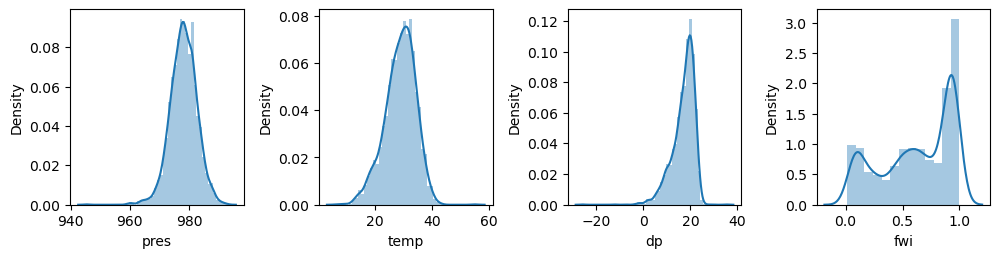

In [437]:
features = list(sfc_df.columns)
features.remove('ape')
plt.subplots(figsize=(30,20))
 
for i, col in enumerate(features):
    plt.subplot(8,12, i + 1)
    sb.distplot(sfc_df[col])
plt.tight_layout()
plt.show()

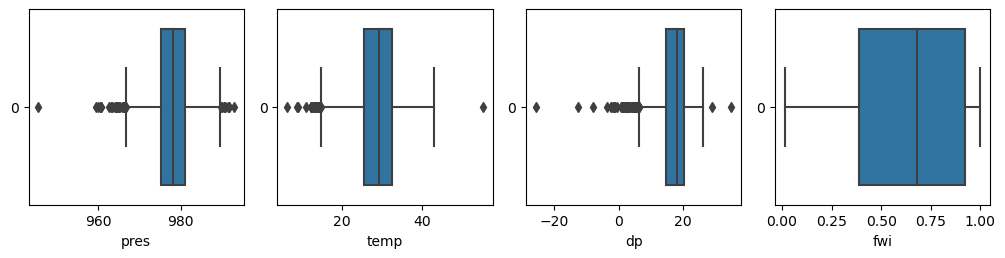

In [438]:
plt.subplots(figsize=(30,20))
 
for i, col in enumerate(features):
    plt.subplot(8,12, i + 1)
    sb.boxplot(data=sfc_df[col], orient='h')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

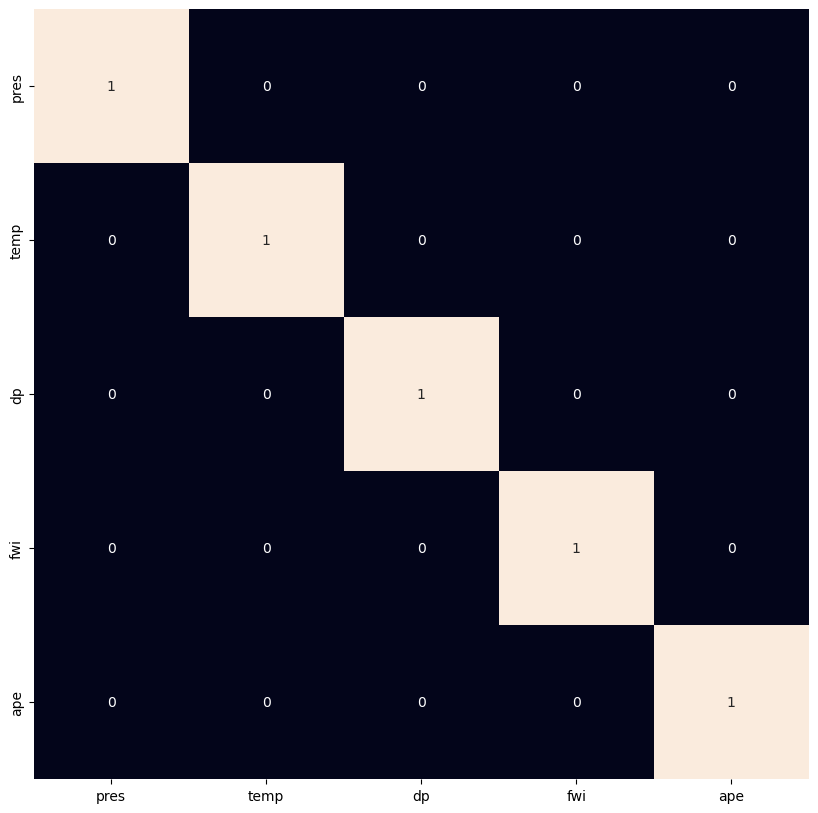

In [461]:
plt.figure(figsize=(10,10))
sb.heatmap(sfc_df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

## Modeling steps

In [440]:
features = sfc_df.drop('ape', axis=1)
target = sfc_df.ape

X_train, X_test, y_train, y_test = train_test_split(features,
                                      target,
                                      test_size=0.2,
                                      stratify=target,
                                      random_state=2)
 
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=22)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# scaler = StandardScaler()
# X = scaler.fit_transform(X_resampled)
# X_test = scaler.transform(X_test)

param_dist = {'n_estimators': randint(50, 500),
              'max_depth': randint(1, 50)} 

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_resampled, y_resampled)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 27, 'n_estimators': 410}


In [441]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7765726681127982


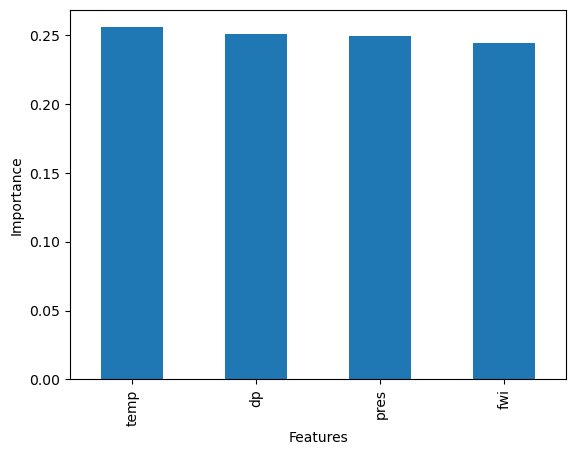

In [462]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test.columns).sort_values(ascending=False)
plt.xlabel('Features')
plt.ylabel('Importance')
feature_importances.plot.bar();

In [450]:
l = best_rf.feature_importances_
pd.Series(l).sort_values(ascending=False)

1    0.255764
2    0.250610
0    0.249121
3    0.244506
dtype: float64

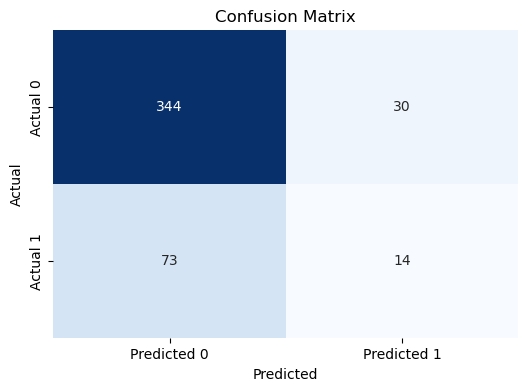

In [452]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()